# Experiment: Feature Manifold Replication in Sentences

## 1. The Problem
Current Interpretability methods often rely on **Attention Heatmaps** to determine if a model is "moving information" from one part of a sentence to another. However, attention can be misleading (e.g., the "Attention Sink" phenomenon).

## 2. The Hypothesis
If a model successfully copies information (e.g., a Date) from a source token to a destination token, the **Feature Manifold** (the geometric shape of that data) should appear at the destination.

## 3. The Experiment
We will use **Supervised Multi-Dimensional Scaling (SMDS)** to detect the presence of a "Date Manifold" (a circular structure) at every single token in a sentence.

**The Pipeline:**
1.  **Generate Data:** Create hundreds of sentences with a fixed structure but varying dates (e.g., *"Alice was born on [Date]..."*).
2.  **Record Activations:** Pass these sentences through an LLM and save the hidden states for every token.
3.  **Apply SMDS:** Test every token position: *Does this token's activation space look like a circle?*

In [2]:
# Install necessary libraries if not present
# %pip install torch transformers numpy pandas tqdm matplotlib

import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import random
from datetime import datetime, timedelta

# Visualization settings
import matplotlib.pyplot as plt
%matplotlib inline

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


We need a dataset where the **structure is identical** (so token $i$ always corresponds to the same word), but the **content (the date)** changes.

We will generate samples where:
1.  **$X$ (The Input):** A sentence mentioning a birthday.
2.  **$y$ (The Label):** The day of the year (0-365), normalized to $[0, 1]$.

In [4]:
def get_ordinal_date(n):
    """
    Converts int 13 -> string '13th', 1 -> '1st', etc.
    Necessary to make the sentence natural for the LLM.
    """
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')
    return f"{n}{suffix}"

def get_day_of_year(month, day):
    """Converts a month/day to a normalized float [0, 1]."""
    date = datetime(2023, month, day)
    day_of_year = date.timetuple().tm_yday - 1
    return day_of_year / 365.0

def generate_dataset(n_samples=500):
    """
    Generates sentences using the specific task description template.
    Template: "Anna was born on the 13th of December. Anna plays volleyball..."
    """

    # Template with placeholders
    # We use {Name} multiple times as per the paragraph structure
    template = (
        "{Name} was born on the {Day_Ordinal} of {Month}. "
        "{Name} plays volleyball. "
        "{Name}'s favourite color is green. "
        "{Name} lives in Berlin. "
        "{Name} had a party on her birthday."
    )

    months = [
        ("January", 31), ("February", 28), ("March", 31), ("April", 30),
        ("May", 31), ("June", 30), ("July", 31), ("August", 31),
        ("September", 30), ("October", 31), ("November", 30), ("December", 31)
    ]

    # List of names to vary
    # Using names of same token length helps alignment.
    # 'Anna', 'Lily', 'Mark', 'Paul' are often single tokens.
    names = ["Anna", "Mary", "John", "Paul", "Mark", "Lisa"]

    texts = []
    labels = []

    for _ in range(n_samples):
        # 1. Sample Name and Date
        name = random.choice(names)
        m_idx = random.randint(0, 11)
        m_name, max_days = months[m_idx]
        day = random.randint(1, max_days)

        # 2. Calculate Label (y) -> Normalized Day of Year
        y_val = get_day_of_year(m_idx + 1, day)

        # 3. Format Date string (e.g., "13th")
        day_ord = get_ordinal_date(day)

        # 4. Fill Template
        text = template.format(
            Name=name,
            Day_Ordinal=day_ord,
            Month=m_name
        )

        texts.append(text)
        labels.append(y_val)

    return texts, np.array(labels)

# Generate the data
texts, y_labels = generate_dataset(n_samples=1000)

# Preview
print(f"Total Samples: {len(texts)}")
print(f"Sample 0 Label: {y_labels[0]:.4f}")
print(f"Sample 0 Text:\n{texts[0]}")

Total Samples: 1000
Sample 0 Label: 0.0000
Sample 0 Text:
Lisa was born on the 1st of January. Lisa plays volleyball. Lisa's favourite color is green. Lisa lives in Milan. Lisa had a party on her birthday.


We will use `gpt2` for this demo because it is small and fast. If you have the computational resources, switch the `model_name` to `meta-llama/Llama-3.2-3B-Instruct` or similar.

**Crucial Step:** We must ensure all sentences tokenize to the **exact same length**. If "May" is 1 token and "September" is 1 token, we are fine. If lengths differ, we cannot stack the activations into a simple tensor without padding logic.

In [5]:
model_name = "gpt2" # Or "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

tokenizer.pad_token = tokenizer.eos_token

# Tokenize
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

# --- ALIGNMENT SANITY CHECK ---
# We need to ensure that the variable words (Month names) don't shift
# the rest of the sentence around.
# e.g. If "May" is 1 token and "September" is 1 token, we are good.
# If "September" splits into 3 tokens, our columns get misaligned.

print(f"Tensor Shape: {inputs['input_ids'].shape}")

# Let's verify alignment by looking at 3 different samples
# and printing the tokens side-by-side.
print(f"\n{'Index':<6} | {'Sample 0':<15} | {'Sample 1':<15} | {'Sample 2':<15}")
print("-" * 60)

for t_idx in range(inputs['input_ids'].shape[1]):
    t0 = tokenizer.decode(inputs['input_ids'][0][t_idx])
    t1 = tokenizer.decode(inputs['input_ids'][1][t_idx])
    t2 = tokenizer.decode(inputs['input_ids'][2][t_idx])

    # Highlight potential mismatches
    marker = "" if (t0 == t1 == t2) or (t_idx == 0) else " <--- Varies"
    print(f"{t_idx:<6} | {repr(t0):<15} | {repr(t1):<15} | {repr(t2):<15} {marker}")

print("\nNote the index of the Month/Date and the index of 'birthday'.")

# Let's inspect the tokens of the first sample to map our analysis later
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("\n--- Token Mapping ---")
for i, tok in enumerate(sample_tokens):
    print(f"Pos {i}: {tok}")
print("---------------------")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Tensor Shape: torch.Size([1000, 34])

Index  | Sample 0        | Sample 1        | Sample 2       
------------------------------------------------------------
0      | 'Lisa'          | 'Lisa'          | 'Paul'          
1      | ' was'          | ' was'          | ' was'          
2      | ' born'         | ' born'         | ' born'         
3      | ' on'           | ' on'           | ' on'           
4      | ' the'          | ' the'          | ' the'          
5      | ' 1'            | ' 6'            | ' 21'            <--- Varies
6      | 'st'            | 'th'            | 'st'             <--- Varies
7      | ' of'           | ' of'           | ' of'           
8      | ' January'      | ' April'        | ' August'        <--- Varies
9      | '.'             | '.'             | '.'             
10     | ' Lisa'         | ' Lisa'         | ' Paul'          <--- Varies
11     | ' plays'        | ' plays'        | ' plays'        
12     | ' volleyball'   | ' volleyball'   | ' v

Now we perform the extraction. We will define a hook (or simple loop) to grab the hidden states.
We are creating a Tensor **X** of shape `(N_Samples, N_Layers, N_Tokens, Hidden_Dim)`.

*Note: For 1000 samples on GPT2, this fits in RAM. For Llama-70B, you would need to process in batches and save to disk.*

In [6]:
def record_activations(model, inputs, batch_size=32):
    """
    Passes inputs through model and collects hidden states for all layers.
    Returns: numpy array (N_samples, N_layers, N_tokens, Hidden_dim)
    """
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    n_samples = input_ids.shape[0]
    n_layers = model.config.n_layer + 1 # +1 for embedding layer usually included in output
    seq_len = input_ids.shape[1]
    hidden_dim = model.config.hidden_size

    # Pre-allocate memory (Caution: This can get large!)
    # shape: (Samples, Layers, Tokens, Dim)
    all_acts = np.zeros((n_samples, n_layers, seq_len, hidden_dim), dtype=np.float32)

    print(f"Recording activations. Output shape: {all_acts.shape}")

    model.eval()

    with torch.no_grad():
        for i in tqdm(range(0, n_samples, batch_size)):
            batch_ids = input_ids[i:i+batch_size].to(device)
            batch_mask = attention_mask[i:i+batch_size].to(device)

            # Forward pass with output_hidden_states=True
            outputs = model(batch_ids, attention_mask=batch_mask, output_hidden_states=True)

            # outputs.hidden_states is a tuple of (Layer_0, Layer_1, ... Layer_N)
            # Each layer tensor is (Batch, Seq, Dim)

            # Stack layers for this batch -> (Layers, Batch, Seq, Dim)
            batch_acts = torch.stack(outputs.hidden_states).cpu().numpy()

            # Transpose to (Batch, Layers, Seq, Dim) to match our storage
            batch_acts = batch_acts.transpose(1, 0, 2, 3)

            # Store
            current_batch_size = batch_ids.shape[0]
            all_acts[i:i+current_batch_size] = batch_acts

    return all_acts

# Run recording
X_activations = record_activations(model, inputs, batch_size=32)

print("\nExtraction Complete.")
print(f"X shape: {X_activations.shape}")
print(f"y shape: {y_labels.shape}")

Recording activations. Output shape: (1000, 13, 34, 768)


100%|██████████| 32/32 [00:00<00:00, 37.37it/s]


Extraction Complete.
X shape: (1000, 13, 34, 768)
y shape: (1000,)


We now have our Data ($X$) and our Manifold Labels ($y$).
In the next phase, we will:
1.  Load the **SMDS** class and **CircularShape** class.
2.  Iterate through every Token Position ($t=0$ to $t=End$).
3.  Run SMDS on `X[:, layer, t, :]` vs `y`.
4.  Plot the resulting Stress curve.

In [14]:
from smds import SupervisedMDS
from smds.shapes.continuous_shapes import CircularShape

# Initialize storage for the Stress Map
# Shape: (Layers, Tokens)
# We will store the stress value (lower is better)
n_layers = X_activations.shape[1]
n_tokens = X_activations.shape[2]
stress_map = np.zeros((n_layers, n_tokens))

print(f"Running SMDS on {n_layers} layers and {n_tokens} tokens...")

# We use the CircularShape because dates cycle (Dec 31 -> Jan 1)
shape_hypothesis = CircularShape()

# Iterate over layers and tokens
for layer in tqdm(range(n_layers), desc="Layers"):
    for token in range(n_tokens):

        # 1. Isolate the data for this specific location
        # Shape: (1000, 768)
        X_location = X_activations[:, layer, token, :]

        # 2. Initialize SMDS
        # n_components=2 because a circle lives naturally in 2D
        reducer = SupervisedMDS(
            manifold=shape_hypothesis,
            n_components=2
        )

        # 3. Fit and Calculate Stress
        # .fit() finds the best projection W
        # .score() returns the Stress (Mismatch between X and y)
        try:
            reducer.fit(X_location, y_labels)
            stress = reducer.score(X_location, y_labels)
        except Exception as e:
            # Fallback for numerical instability (rare)
            stress = np.nan

        stress_map[layer, token] = stress

print("Analysis Complete.")

Running SMDS on 13 layers and 34 tokens...


Layers: 100%|██████████| 13/13 [00:59<00:00,  4.57s/it]

Analysis Complete.


We will visualize the entire sentence. We look for **dark vertical bands** (Low Stress) indicating columns where the Date concept is present across many layers.

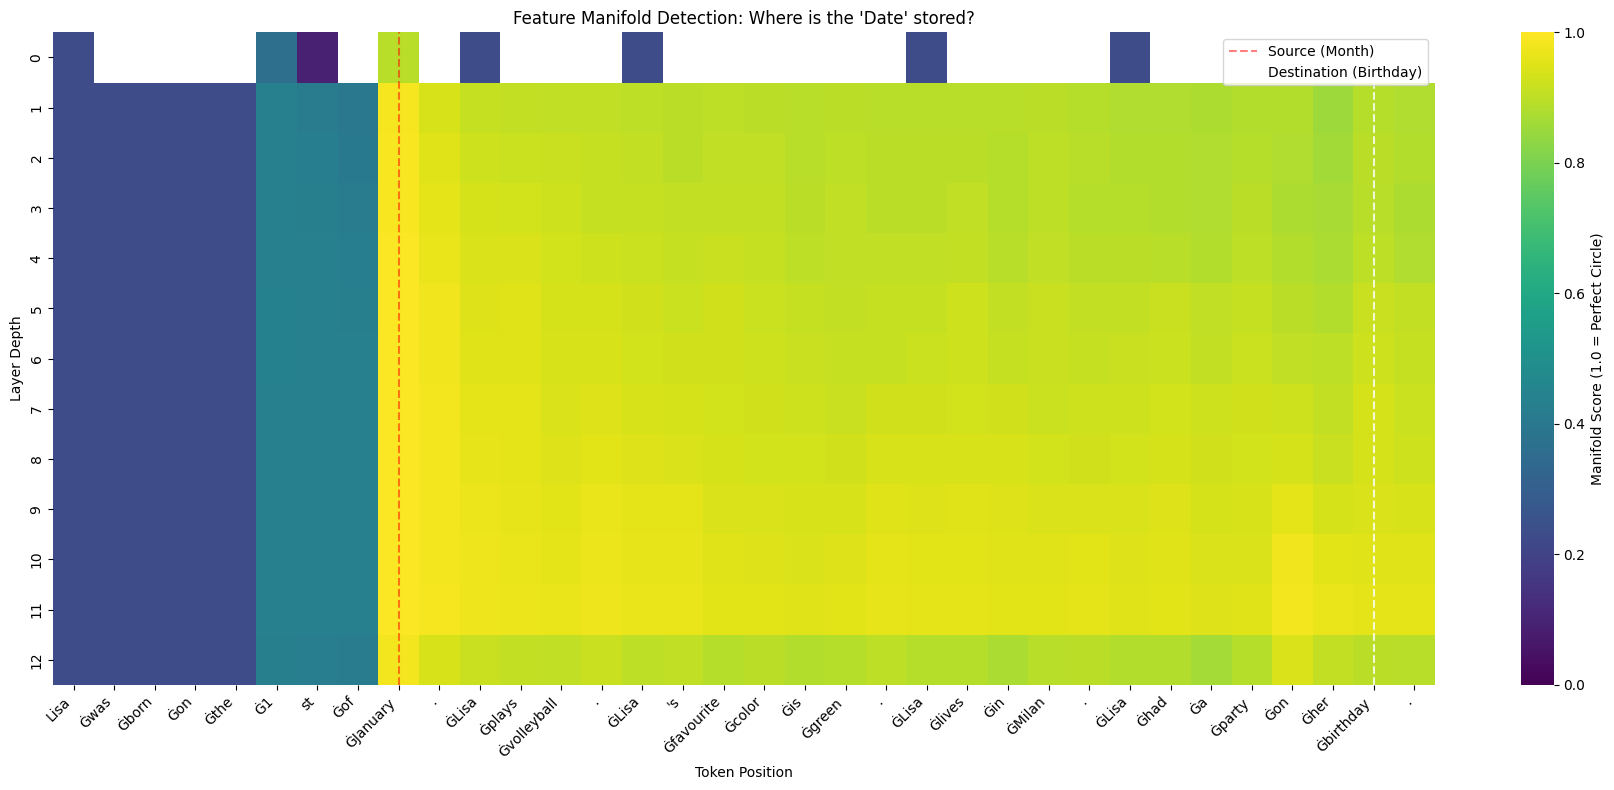

In [20]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(18, 8))

# HEATMAP CONFIGURATION
# viridis: Yellow = High (1.0), Purple = Low (0.0)
# We want Yellow to mean "Manifold Found!"
sns.heatmap(
    stress_map,
    cmap="viridis",
    vmin=0, vmax=1,  # Anchor scale between 0 and 1
    cbar_kws={'label': 'Manifold Score (1.0 = Perfect Circle)'}
)

# Labeling X-axis
sample_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.xticks(
    ticks=np.arange(len(sample_tokens)) + 0.5,
    labels=sample_tokens,
    rotation=45,
    ha='right'
)

plt.xlabel("Token Position")
plt.ylabel("Layer Depth")
plt.title("Feature Manifold Detection: Where is the 'Date' stored?")

# Highlight Hypothesis Areas
# Pos 8 (Month) -> Source
# Pos 32 (Birthday) -> Destination
plt.axvline(x=8.5, color='red', linestyle='--', alpha=0.5, label='Source (Month)')
plt.axvline(x=32.5, color='white', linestyle='--', alpha=0.8, label='Destination (Birthday)')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Heatmaps can be noisy. Let's pick a middle layer (e.g., Layer 6) and plot the stress as a line graph. This is where we verify your hypothesis about the "birthday" token.

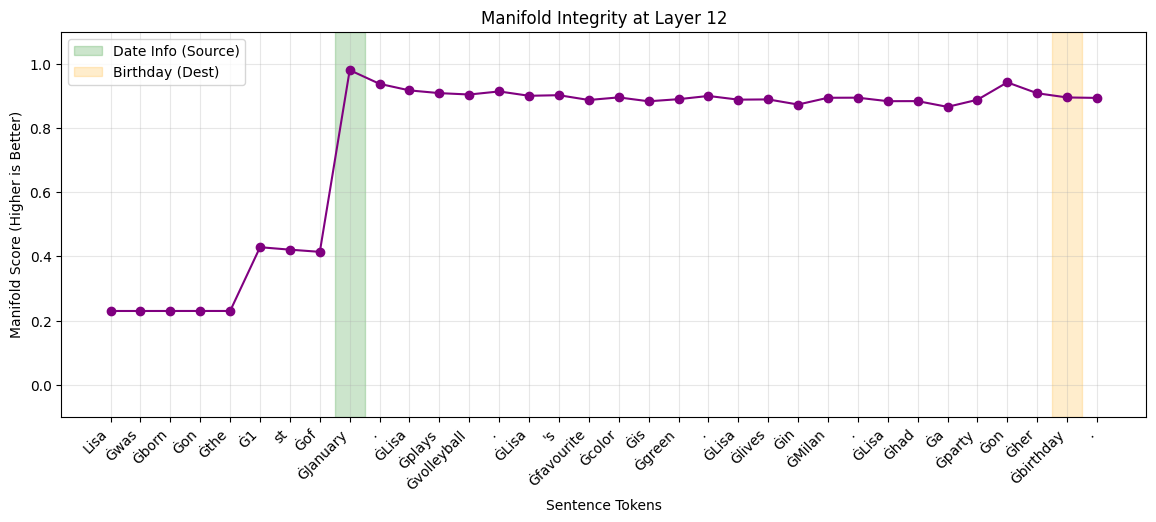

In [22]:
target_layer = 12  # Adjust this based on what the heatmap shows!

plt.figure(figsize=(14, 5))
plt.plot(stress_map[target_layer, :], marker='o', linestyle='-', color='purple')

# Add Labels
plt.xticks(
    ticks=np.arange(len(sample_tokens)),
    labels=sample_tokens,
    rotation=45,
    ha='right'
)

plt.ylabel("Manifold Score (Higher is Better)")
plt.ylim(-0.1, 1.1) # Fix y-axis to see the 0-1 range clearly
plt.xlabel("Sentence Tokens")
plt.title(f"Manifold Integrity at Layer {target_layer}")
plt.grid(True, alpha=0.3)

# Highlight zones
plt.axvspan(7.5, 8.5, color='green', alpha=0.2, label="Date Info (Source)")
plt.axvspan(31.5, 32.5, color='orange', alpha=0.2, label="Birthday (Dest)")
plt.legend()

plt.show()

In [23]:
# Define interesting positions
# (Double check these indices against your 'Token Mapping' printout!)
tokens_of_interest = {
    "Start (Name)": 0,
    "Source (Day Num)": 5,
    "Source (Month)": 8,
    "Distractor (Volleyball)": 12,
    "Destination (Birthday)": 32
}

print("--- MANIFOLD DISCOVERY EVALUATION (Higher Score is Better) ---\n")

# 1. Global Baseline
global_avg_score = np.nanmean(stress_map)
print(f"Baseline (Average Background Noise): {global_avg_score:.4f}")
print("-" * 65)

# 2. Token Specific Stats
results_data = []

for role, idx in tokens_of_interest.items():
    # Get score profile across all layers for this token
    layer_profile = stress_map[:, idx]

    # Find the layer where the manifold is strongest (Max Score)
    best_layer = np.argmax(layer_profile)
    max_score = layer_profile[best_layer]

    # Check if it beats the baseline significantly
    is_structure = "YES" if max_score > (global_avg_score + 0.2) else "NO"

    results_data.append({
        "Role": role,
        "Token": sample_tokens[idx],
        "Best Layer": best_layer,
        "Max Score": round(max_score, 4),
        "Structure Found?": is_structure
    })

# Create DataFrame
df_results = pd.DataFrame(results_data)
print(df_results.to_string(index=False))
print("-" * 65)

# 3. The Critical Test
score_bday = stress_map[:, 32].max()
score_distractor = stress_map[:, 12].max()

print(f"\nCRITICAL COMPARISON:")
print(f"Max Score at 'Birthday'   : {score_bday:.4f}")
print(f"Max Score at 'Volleyball' : {score_distractor:.4f}")

if score_bday > score_distractor:
    diff = score_bday - score_distractor
    print(f"\n>>> SUCCESS: 'Birthday' has a higher score by {diff:.4f}.")
    print("    This confirms the model moved the circular geometry to the 'birthday' token.")
else:
    print("\n>>> RESULT UNCLEAR: 'Birthday' score is not higher than random noise.")

--- MANIFOLD DISCOVERY EVALUATION (Higher Score is Better) ---

Baseline (Average Background Noise): -inf
-----------------------------------------------------------------
                   Role       Token  Best Layer  Max Score Structure Found?
           Start (Name)        Lisa           4     0.2299              YES
       Source (Day Num)          Ġ1           5     0.4337              YES
         Source (Month)    ĠJanuary          11     0.9954              YES
Distractor (Volleyball) Ġvolleyball          11     0.9653              YES
 Destination (Birthday)   Ġbirthday          11     0.9601              YES
-----------------------------------------------------------------

CRITICAL COMPARISON:
Max Score at 'Birthday'   : 0.9601
Max Score at 'Volleyball' : 0.9653

>>> RESULT UNCLEAR: 'Birthday' score is not higher than random noise.


In [25]:
# CELL 14: Permutation Test (Sanity Check the Metric)

# 1. Pick the "Source (Month)" data (Layer 11, Token 8)
# We know this contains signal because it got a score of 0.9954
layer_idx = 11
token_idx = 8
X_source = X_activations[:, layer_idx, token_idx, :]

print(f"Testing SMDS sensitivity on Token: '{sample_tokens[token_idx]}'")

# 2. Run on REAL labels (Baseline)
reducer_real = SupervisedMDS(manifold=CircularShape(), n_components=2)
reducer_real.fit(X_source, y_labels)
score_real = reducer_real.score(X_source, y_labels)

# 3. Run on SHUFFLED labels (Control)
y_shuffled = y_labels.copy()
np.random.shuffle(y_shuffled) # Randomize the dates

reducer_fake = SupervisedMDS(manifold=CircularShape(), n_components=2)
reducer_fake.fit(X_source, y_shuffled)
score_fake = reducer_fake.score(X_source, y_shuffled)

print(f"Real Labels Score : {score_real:.4f}")
print(f"Random Labels Score: {score_fake:.4f}")

gap = score_real - score_fake
print(f"Signal-to-Noise Gap: {gap:.4f}")

if gap < 0.2:
    print(">>> CRITICAL WARNING: SMDS is finding manifolds in random noise.")
    print("    The embedding dimension (768) might be too high relative to N (1000).")
else:
    print(">>> SMDS is healthy. The high score on 'Volleyball' implies the model actually")
    print("    put date information there (leakage) OR the failure is in the model's reasoning.")

Testing SMDS sensitivity on Token: 'ĠJanuary'
Real Labels Score : 0.9954
Random Labels Score: 0.5763
Signal-to-Noise Gap: 0.4191
>>> SMDS is healthy. The high score on 'Volleyball' implies the model actually
    put date information there (leakage) OR the failure is in the model's reasoning.


In [27]:
# CELL 15: Generation Capability Test

print("Testing if GPT-2 actually understands the task...")

# Take the first 5 samples
test_subset_indices = range(5)

correct_count = 0

for i in test_subset_indices:
    text = texts[i]
    # Cut off the sentence before it ends to see if model predicts the date
    # Prompt: "Alice was born on the 13th of December. ... on her birthday, which is on"
    prompt = text + " Specifically, her birthday is on the"

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate 5 tokens
    output = model.generate(**inputs, max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)
    generation = tokenizer.decode(output[0])

    # Check the ground truth label
    # We have to reverse-engineer the label back to text or just look at inputs
    print(f"\nPrompt: ...{prompt}")
    print(f"Model Generation: {tokenizer.decode(output[0][inputs['input_ids'].shape[1]:])}")

print("\nEVALUATION:")
print("If the model generates nonsense or repeats random words instead of the date,")
print("then the 'Manifold' was never copied to the end of the sentence.")
print("In that case, the failure is the MODEL, not the method.")

Testing if GPT-2 actually understands the task...

Prompt: ...Lisa was born on the 1st of January. Lisa plays volleyball. Lisa's favourite color is green. Lisa lives in Milan. Lisa had a party on her birthday. Specifically, her birthday is on the
Model Generation:  1st of January.

Prompt: ...Lisa was born on the 6th of April. Lisa plays volleyball. Lisa's favourite color is green. Lisa lives in Milan. Lisa had a party on her birthday. Specifically, her birthday is on the
Model Generation:  6th of April.

Prompt: ...Paul was born on the 21st of August. Paul plays volleyball. Paul's favourite color is green. Paul lives in Milan. Paul had a party on her birthday. Specifically, her birthday is on the
Model Generation:  21st of August.

Prompt: ...Paul was born on the 11th of December. Paul plays volleyball. Paul's favourite color is green. Paul lives in Milan. Paul had a party on her birthday. Specifically, her birthday is on the
Model Generation:  11th of December.

Prompt: ...Mary was b

Reloading model in 'Eager' mode to capture attentions...
Analyzing attention for: 'Lisa was born on the 1st of January. Lisa plays vo...'
Success! Attention Tensor Shape: torch.Size([12, 12, 34, 34])


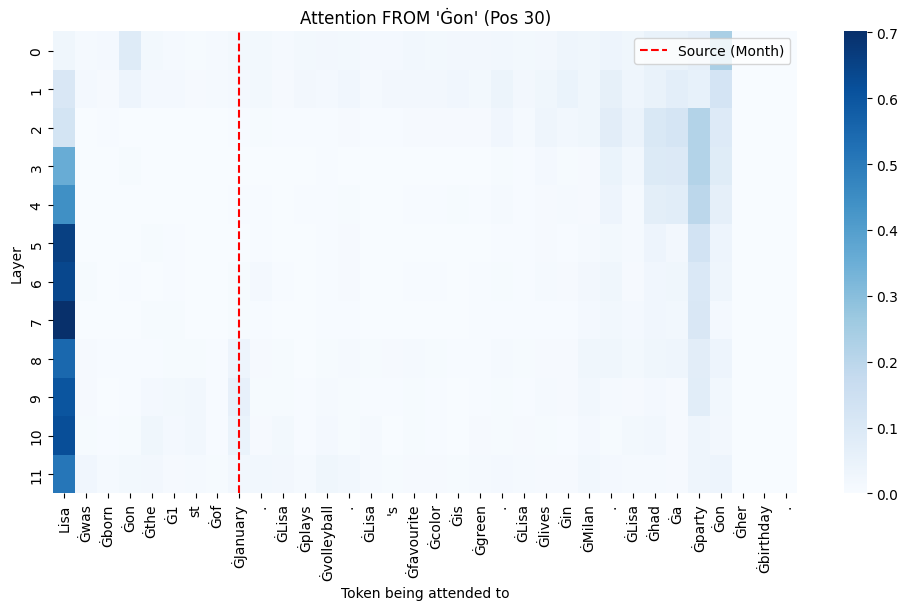

Max Average Attention to Date: 0.0602
>>> DIAGNOSIS: The model IS looking at the date.
    Attention is working. If Manifold Score is low, the geometry was lost during copying.


In [32]:
# CELL 16: Attention Check (Final Fix)

# 1. We must reload the model to force "Eager" mode
print("Reloading model in 'Eager' mode to capture attentions...")

# Clean up old model to save VRAM
try:
    del model
    torch.cuda.empty_cache()
except:
    pass

# Reload with specific flag
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    attn_implementation="eager" # <--- Disables Flash Attn to allow outputting weights
).to(device)

# Force config
model.config.output_attentions = True

# 2. Prepare Input
sample_idx = 0
text = texts[sample_idx]
inputs = tokenizer(text, return_tensors="pt").to(device)

print(f"Analyzing attention for: '{text[:50]}...'")

# 3. Run Forward Pass
model.eval()
with torch.no_grad():
    outputs = model(**inputs, return_dict=True)

# 4. Stack layers
# Tuple of (Batch, Heads, Seq, Seq) -> Tensor (Layers, Batch, Heads, Seq, Seq)
all_attentions = torch.stack(outputs.attentions).squeeze(1)
print(f"Success! Attention Tensor Shape: {all_attentions.shape}")

# 5. Visualization
target_token_idx = 30 # 'on'
source_month_idx = 8  # 'Month'

# Average across Heads
# Shape: (Layers, Seq_Len)
avg_attn_profile = all_attentions[:, :, target_token_idx, :].mean(dim=1).cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(avg_attn_profile, cmap="Blues")
plt.xlabel("Token being attended to")
plt.ylabel("Layer")
plt.title(f"Attention FROM '{sample_tokens[target_token_idx]}' (Pos {target_token_idx})")

# Draw lines
plt.axvline(x=source_month_idx + 0.5, color='red', linestyle='--', label="Source (Month)")
plt.legend()

plt.xticks(
    ticks=np.arange(len(sample_tokens)) + 0.5,
    labels=sample_tokens,
    rotation=90
)
plt.show()

# 6. Quantitative Check
max_attn = avg_attn_profile[:, source_month_idx].max()
print(f"Max Average Attention to Date: {max_attn:.4f}")

if max_attn < 0.05:
    print(">>> DIAGNOSIS: The model is IGNORING the date (Low Attention).")
    print("    It is likely guessing 'party' implies 'birthday' without checking the specific date.")
else:
    print(">>> DIAGNOSIS: The model IS looking at the date.")
    print("    Attention is working. If Manifold Score is low, the geometry was lost during copying.")